# Causal Language Model 
Used to predict sentiment tags using a following sentence of "I feel ____" blank

This notebook attempts to do sentiment classification using a Causal Lanugage Model, using few-shot learning, based on the ideas in https://aclanthology.org/2021.eacl-main.20.pdf

Reference Notebooks:
https://github.com/huggingface/notebooks/blob/master/transformers_doc/task_summary.ipynb
 
 NOTE: this notebook NOT used in final paper!

## Setup host


In [ ]:
# Transformers installation
! pip install transformers datasets

     |████████████████████████████████| 3.8 MB 4.4 MB/s 
     |████████████████████████████████| 325 kB 8.8 MB/s 
     |████████████████████████████████| 6.5 MB 19.3 MB/s 
     |████████████████████████████████| 895 kB 10.5 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 67 kB 2.5 MB/s 
     |████████████████████████████████| 212 kB 38.0 MB/s 
     |████████████████████████████████| 136 kB 33.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.1 MB/s 
     |████████████████████████████████| 127 kB 44.9 MB/s 
     |████████████████████████████████| 144 kB 35.3 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 


In [ ]:
import transformers

print(transformers.__version__)

In [ ]:
# connect to drive
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)


## Set up model


### Load base model


In [ ]:
from transformers import TFAutoModelForCausalLM, AutoTokenizer, tf_top_k_top_p_filtering
import tensorflow as tf

base_model = TFAutoModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/266-NLP-data/roberta_pretrained_500000_10epoch")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# maximum length for a string
max_length = 80

### Build custom F1 function


In [ ]:
from keras import backend as K

def custom_f1(y_true, y_pred):

  def recall_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision
  
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
base_model.summary()

### Build classication model around prediction


In [ ]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

def create_classification_model(model=base_model,
                                hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam(),
                                metrics=['accuracy']):
    """
    Build a simple classification model with MLM model pretrained on our data. 
    Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')
    
    inputs = {'input_ids': input_ids,
              'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in base_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    pretrained_model_output = base_model(inputs)

# TODO: This needs to be updated to find the masked token, this is the classifer one for the start token
    classification_token = tf.keras.layers.Lambda(
        lambda x: x[:,0,:], name='get_masked_vector')(
            pretrained_model_output[0])


    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    classification = tf.keras.layers.Dense(28, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=metrics)


    return classification_model

In [ ]:
optimizer = AdamWeightDecay(lr=2e-5, weight_decay_rate=0.01)

model = create_classification_model(base_model,
                                    optimizer = optimizer,
                                    train_layers = 3,
                                    metrics=['accuracy',custom_f1])

model.summary()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 80)]         0           []                               
                                                                                                  
 tf_roberta_for_causal_lm (TFRo  TFCausalLMOutputWit  124697433  ['attention_mask_layer[0][0]',   
 bertaForCausalLM)              hCrossAttentions(lo               'input_ids_layer[0][0]']        
                                ss=None, logits=(No                                           

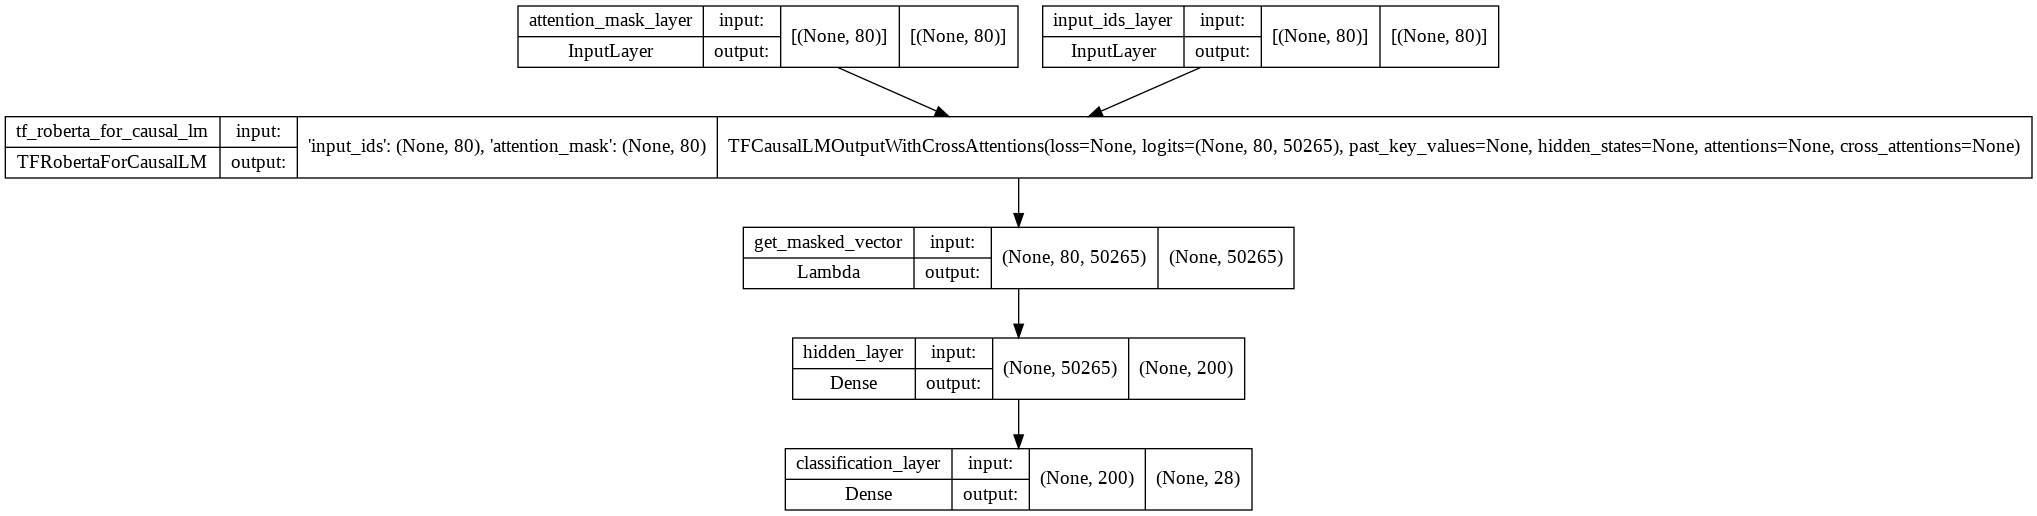

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Load and prepare training data

### Specify canonical labels


In [ ]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

In [ ]:

import pandas as pd

##datasets = load_dataset("csv", 
#                         data_files={"train": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_training.csv",
#                                     "validation": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_val.csv",
#                                     "test": "/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_test.csv"})

#print(datasets)
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_test.csv")
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_training.csv")
val = pd.read_csv("/content/drive/My Drive/Colab Notebooks/266-NLP-data/strat_val.csv")



### fix column names


In [ ]:

train=train.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
test=test.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
val=val.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})

train_str = train[['target_string']].to_numpy() 
test_str = test[['target_string']].to_numpy() 
val_str = val[['target_string']].to_numpy() 

train_label = train[LABELS].to_numpy()

test_label = test[LABELS].to_numpy() 

val_label = val[LABELS].to_numpy() 

### Function to append prompt string, and tokenize

In [ ]:
suffix = " I feel "+ tokenizer.mask_token

#note:not used in this version
def extend_and_tokenize_function(strings_df, local_tokenizer=tokenizer,string_field="target_string",):
    extended_strings = [x + suffix for x in strings_df[string_field]]
    return local_tokenizer(extended_strings)

### Tokenize data sets

In [ ]:

x_train = tokenizer([str(x) + suffix for x in train_str],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = train_label


x_test = tokenizer([str(x) + suffix for x in test_str],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = test_label


x_val = tokenizer([str(x)+ suffix for x in val_str],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_val = val_label

In [ ]:
print(x_train)

{'input_ids': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
array([[    0, 48759,  3837, ...,     1,     1,     1],
       [    0, 49329,   178, ...,     1,     1,     1],
       [    0, 49329,  8487, ...,     1,     1,     1],
       ...,
       [    0, 49329,   407, ...,     1,     1,     1],
       [    0, 48759,   152, ...,     1,     1,     1],
       [    0, 49329,  8976, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1604, 80), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


##Train the model with the train data

In [ ]:
history = model.fit([x_train.input_ids,  x_train.attention_mask],
                         y_train,
                         validation_data=([x_test.input_ids,  x_test.attention_mask],
                         y_test),
                        epochs=40,
                        batch_size=53)

Epoch 1/40
31/31 [==============================] - 54s 1s/step - loss: 0.4820 - accuracy: 0.1864 - custom_f1: 0.1395 - val_loss: 0.2339 - val_accuracy: 0.1606 - val_custom_f1: 0.0114
Epoch 2/40
31/31 [==============================] - 38s 1s/step - loss: 0.2263 - accuracy: 0.2089 - custom_f1: 0.1280 - val_loss: 0.1739 - val_accuracy: 0.2435 - val_custom_f1: 0.0646
Epoch 3/40
31/31 [==============================] - 38s 1s/step - loss: 0.1880 - accuracy: 0.2594 - custom_f1: 0.1604 - val_loss: 0.1553 - val_accuracy: 0.3472 - val_custom_f1: 0.3183
Epoch 4/40
31/31 [==============================] - 38s 1s/step - loss: 0.1758 - accuracy: 0.2774 - custom_f1: 0.1879 - val_loss: 0.1536 - val_accuracy: 0.3472 - val_custom_f1: 0.2294
Epoch 5/40
31/31 [==============================] - 38s 1s/step - loss: 0.1671 - accuracy: 0.2999 - custom_f1: 0.2250 - val_loss: 0.1423 - val_accuracy: 0.3886 - val_custom_f1: 0.2588
Epoch 6/40
31/31 [==============================] - 38s 1s/step - loss: 0.1573 -

## Save the trained model

In [ ]:
drive.mount('/content/drive',force_remount=True)
print(type(model))
model.save("/content/drive/My Drive/Colab Notebooks/266-NLP-data/roberta_CLM_trained")

drive.flush_and_unmount()

Mounted at /content/drive
<class 'keras.engine.functional.Functional'>


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/266-NLP-data/roberta_CLM_trained/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/266-NLP-data/roberta_CLM_trained/assets


## Load the Strings to be estimated


In [ ]:
drive.mount('/content/drive',force_remount=True)
target = pd.read_csv("/content/drive/My Drive/Colab Notebooks/266-NLP-data/podcast_sentences_high_conf_100K_for_PLM.csv",nrows=1000)

target_str = target[['string']].to_numpy() 
print(target_str)

Mounted at /content/drive
[["It's in your stomach."]
 ['You see girl bullies.']
 ['Blog called a peek into the Pantry on this blog.']
 ['The line will definitely help you and last you have got to get to the net a lot more often than you are.']
 ["It didn't like it."]
 ['Well before 2013, this is not the Harlem shake.']
 ["Well, I think what you're saying is more like they they make a frame and they can't go beyond that frame."]
 ['We just need a win probably I would say the best time to be playing West Ham.']
 ['So it was a really good show.']
 ["I'm grateful for everything that I go through."]
 ['No, you know not serious.']
 ["To identify both the ear and the hair as her son's as sick as Gail felt over what had happened to her child."]
 ["Yeah, you don't want it was just yeah because yeah, you know, I think like I'm all about sharing passwords, but I want yeah like I want to watch my shit without service like middle."]
 ['He then moves on to how is this appropriate?']
 ['I use for the

### Tokenize target strings

In [ ]:
x_target = tokenizer([str(x) + suffix for x in target_str],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
print(x_target)

{'input_ids': <tf.Tensor: shape=(1000, 80), dtype=int32, numpy=
array([[    0, 49329,   243, ...,     1,     1,     1],
       [    0, 48759,  1185, ...,     1,     1,     1],
       [    0, 48759, 44967, ...,     1,     1,     1],
       ...,
       [    0, 48759,  3084, ...,     1,     1,     1],
       [    0, 49329,   170, ...,     1,     1,     1],
       [    0, 49329,   894, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1000, 80), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


### Run predictions for all strings

In [ ]:
target_predict = model.predict([x_target.input_ids,  x_target.attention_mask], 
                             batch_size=100, 
                             steps=1)



### Save the tagged strings


In [ ]:
#print(target_predict>.5)

print (tf.argmax(target_predict, axis=1))

tf.Tensor(
[27 10 27 20 10 27 10  9  4 15 10  6 10  7 27 10  7 27 27 24 27 20  7  4
 24 10  7 20 27 10  0 20  0 13 27 13 20  0  0 10  9  6 20 20 27 10  4 20
  6 20 27  6  0  9 27  6 22  7 20  0 20 27 10 10  6 20  6 20 15  6  0 10
 14  4 10  7 10 10 20 14 27 20 10 27 15 10 10 20  4 10  4 10  0 21 20 20
  6 10 27 27], shape=(100,), dtype=int64)


0         neutral
1     disapproval
2         neutral
3        optimism
4     disapproval
         ...     
95       optimism
96      confusion
97    disapproval
98        neutral
99        neutral
Length: 100, dtype: object


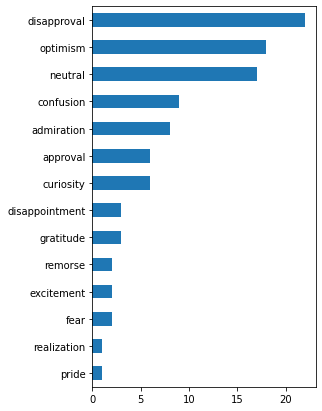

In [ ]:
top_tag = tf.argmax(target_predict, axis=1)
    
tags = pd.Series([LABELS[x] for x in top_tag])
print(tags)

tags.value_counts().plot(kind='barh',figsize=(4,7)).invert_yaxis()

# Hugging face example code



## CLM Example

sequence = f"Hugging Face is based in DUMBO, New York City, and"
inputs = tokenizer(sequence, return_tensors="tf")
input_ids = inputs["input_ids"]

#### get logits of last hidden state
next_token_logits = model(**inputs).logits[:, -1, :]

#### filter
filtered_next_token_logits = tf_top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)

#### sample
next_token = tf.random.categorical(filtered_next_token_logits, dtype=tf.int32, num_samples=1)

generated = tf.concat([input_ids, next_token], axis=1)

resulting_string = tokenizer.decode(generated.numpy().tolist()[0])

print(resulting_string)



## MLM example
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") model = TFAutoModelForMaskedLM.from_pretrained("distilbert-base-cased")

sequence = ( "Distilled models are smaller than the models they mimic. Using them instead of the large " f"versions would help {tokenizer.mask_token} our carbon footprint." )

inputs = tokenizer(sequence, return_tensors="tf") mask_token_index = tf.where(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]

token_logits = model(**inputs).logits mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = tf.math.top_k(mask_token_logits, 5).indices.numpy()

for token in top_5_tokens: print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))